In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# choose outcome, either at discharge or discharge - admission
USE_AS_OUTCOME = ['dc', 'delta'][0]
EXCLUDE_THE_OTHER_MEASURE_ADM = True

# total # of features and a list of all feature names

import pandas as pd
import pickle
import numpy as np
from tabulate import tabulate
import json

# always start from loading the CSV file from previous section
df = pd.read_csv('./data/Cleaned files/Cogan_2_5.csv', low_memory=False, index_col='id')

# load splits
with open('./data/Cleaned files/data_splits.json', 'r') as f:
    split_dict = json.load(f)

print("# of train samples:", len(split_dict["train"]))
print("# of eval samples:", len(split_dict["eval"]))
print("# of test samples:", len(split_dict["test"]))

print("# of valid selfcare train samples:", df.loc[split_dict["train"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare eval samples:", df.loc[split_dict["eval"]]['selfcare_measure_delta'].notna().sum())
print("# of valid selfcare test samples:", df.loc[split_dict["test"]]['selfcare_measure_delta'].notna().sum())

print("# of valid mobility train samples:", df.loc[split_dict["train"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility eval samples:", df.loc[split_dict["eval"]]['mobility_measure_delta'].notna().sum())
print("# of valid mobility test samples:", df.loc[split_dict["test"]]['mobility_measure_delta'].notna().sum())


feature_names = [*df.head()]
feature_dtypes = df.dtypes
print("total # of features:", len(feature_names))

nan_counts = df.isna().sum(axis=0).to_dict()


def tabulate_df(df):
    feature_names = [*df.head()]
    feature_dtypes = df.dtypes
    nan_counts = df.isna().sum(axis=0).to_dict()
    return tabulate([(index, name, feature_dtypes[name], nan_counts[name]) for index, name in enumerate(feature_names)], headers=["Index", "Name", "Dtype", "# of NaNs"], tablefmt="grid")

print(tabulate_df(df))

# load interested predictor and outcome name list
with open('./data/Cleaned files/selected_features.json', 'r') as f:
    selected_feature_dict = json.load(f)
therapy_predictors = selected_feature_dict['therapy_predictors']

predictors = [name for name in df.columns if name not in ['id', 'selfcare_measure_delta', 'mobility_measure_delta', 'selfcare_measure_dc', 'mobility_measure_dc']]


# of train samples: 26656
# of eval samples: 6664
# of test samples: 6664
# of valid selfcare train samples: 26656
# of valid selfcare eval samples: 6664
# of valid selfcare test samples: 6664
# of valid mobility train samples: 26656
# of valid mobility eval samples: 6664
# of valid mobility test samples: 6664
total # of features: 59
+---------+------------------------------------------------+---------+-------------+
|   Index | Name                                           | Dtype   |   # of NaNs |
+=========+================================================+=========+=============+
|       0 | ptindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       1 | otindweek1                                     | float64 |           0 |
+---------+------------------------------------------------+---------+-------------+
|       2 | slpindweek1                                    | float64 

Plot histograms

In [3]:
import matplotlib.pyplot as plt


with open('./data/Cleaned files/standardization_params.json', 'r') as f:
    scaling_params = json.load(f)
print(scaling_params.keys())

dict_keys(['ptindweek1', 'otindweek1', 'slpindweek1', 'ptindweek2', 'otindweek2', 'slpindweek2', 'ptindweek1+2', 'otindweek1+2', 'slpindweek1+2', 'ptindperday', 'otindperday', 'slpindperday', 'ptindextrap', 'otindextrap', 'slpindextrap', 'hearing_adm', 'vision_adm', 'health_lit_adm', 'expression_adm', 'understand_verbal_adm', 'bims_total', 'socisolation_adm', 'selfcare_prior', 'mobility_prior', 'selfcare_measure_adm', 'mobility_measure_adm', 'bladder_incontinence', 'bowel_incontinence', 'pain_sleep_adm', 'age_at_admit', 'los'])


In [4]:
last_df = df

In [5]:
df = last_df.copy()
for varname in scaling_params.keys():
    df[varname] = df[varname] * scaling_params[varname]['std'] + scaling_params[varname]['mean']

In [6]:
last_df = df

In [7]:
df = last_df.copy()

variables = [
    "ptindweek1+2", "otindweek1+2", "slpindweek1+2", "hearing_adm", "vision_adm", 
    "health_lit_adm", "expression_adm", "understand_verbal_adm", "bims_total", 
    "acute_mental_change", "socisolation_adm", "selfcare_prior", "mobility_prior", 
    "selfcare_measure_adm", "mobility_measure_adm", "bladder_incontinence", "bowel_incontinence", 
    "pvd_comorbid", "diabetes_comorbid", "pain_sleep_adm", "pressure_ulcer_adm", "age_at_admit", 
    "los", "sex_male", "marital_status_Unknown", "marital_status_Unmarried", 
    "payor_primary_Medicare_FFS", "payor_primary_Not_listed", "stroke_type_Ischemic", 
    "stroke_type_Other", "hispanic_Yes", "race_Asian", "race_Black_or_African_American", 
    "race_Multiracial", "race_Native_Hawaiian_or_Other_Pacific_Islander", "race_Unknown", 
    "race_White", "low_interest_adm_1", "low_interest_adm_Unknown", "depressed_adm_1", 
    "depressed_adm_Unknown", "falls_hx_Unknown", "falls_hx_Yes", "selfcare_measure_dc", 
    "mobility_measure_dc"
]

print(len(variables))
df = df[variables]

45


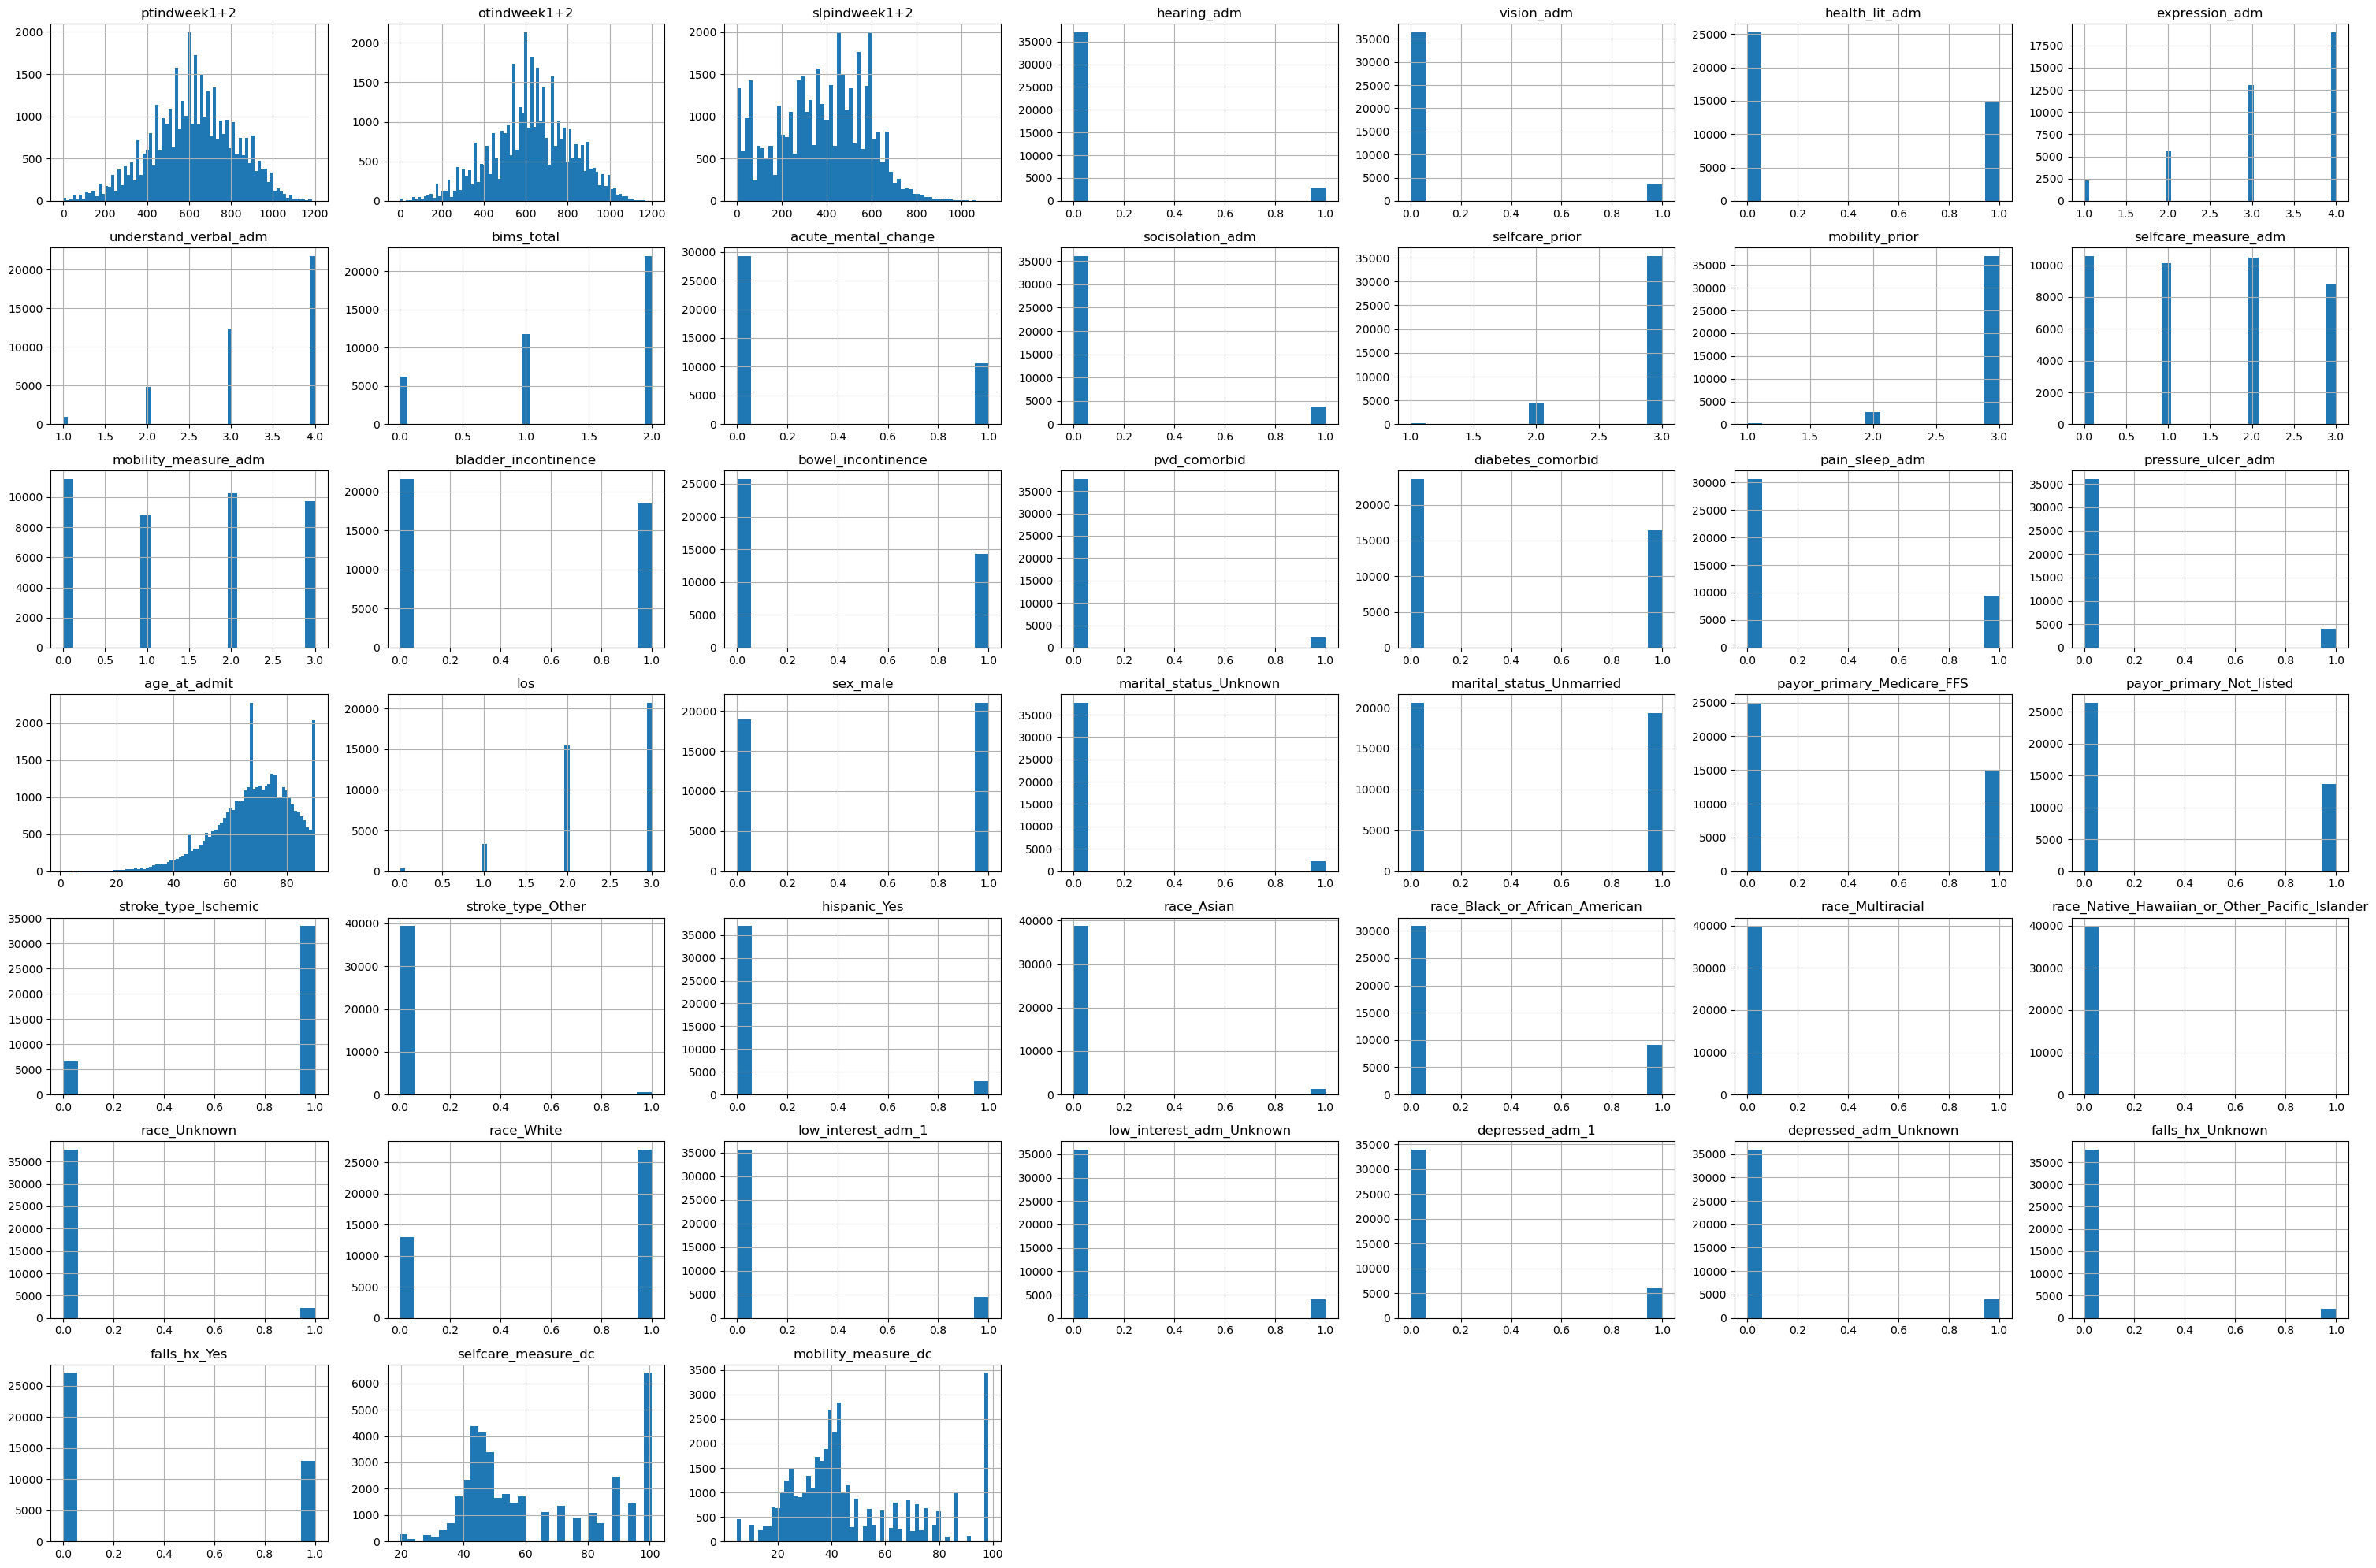

In [8]:
df.hist(bins='auto', figsize=(30, 20))
plt.tight_layout()
plt.savefig("histograms.png", dpi=300)
plt.show()

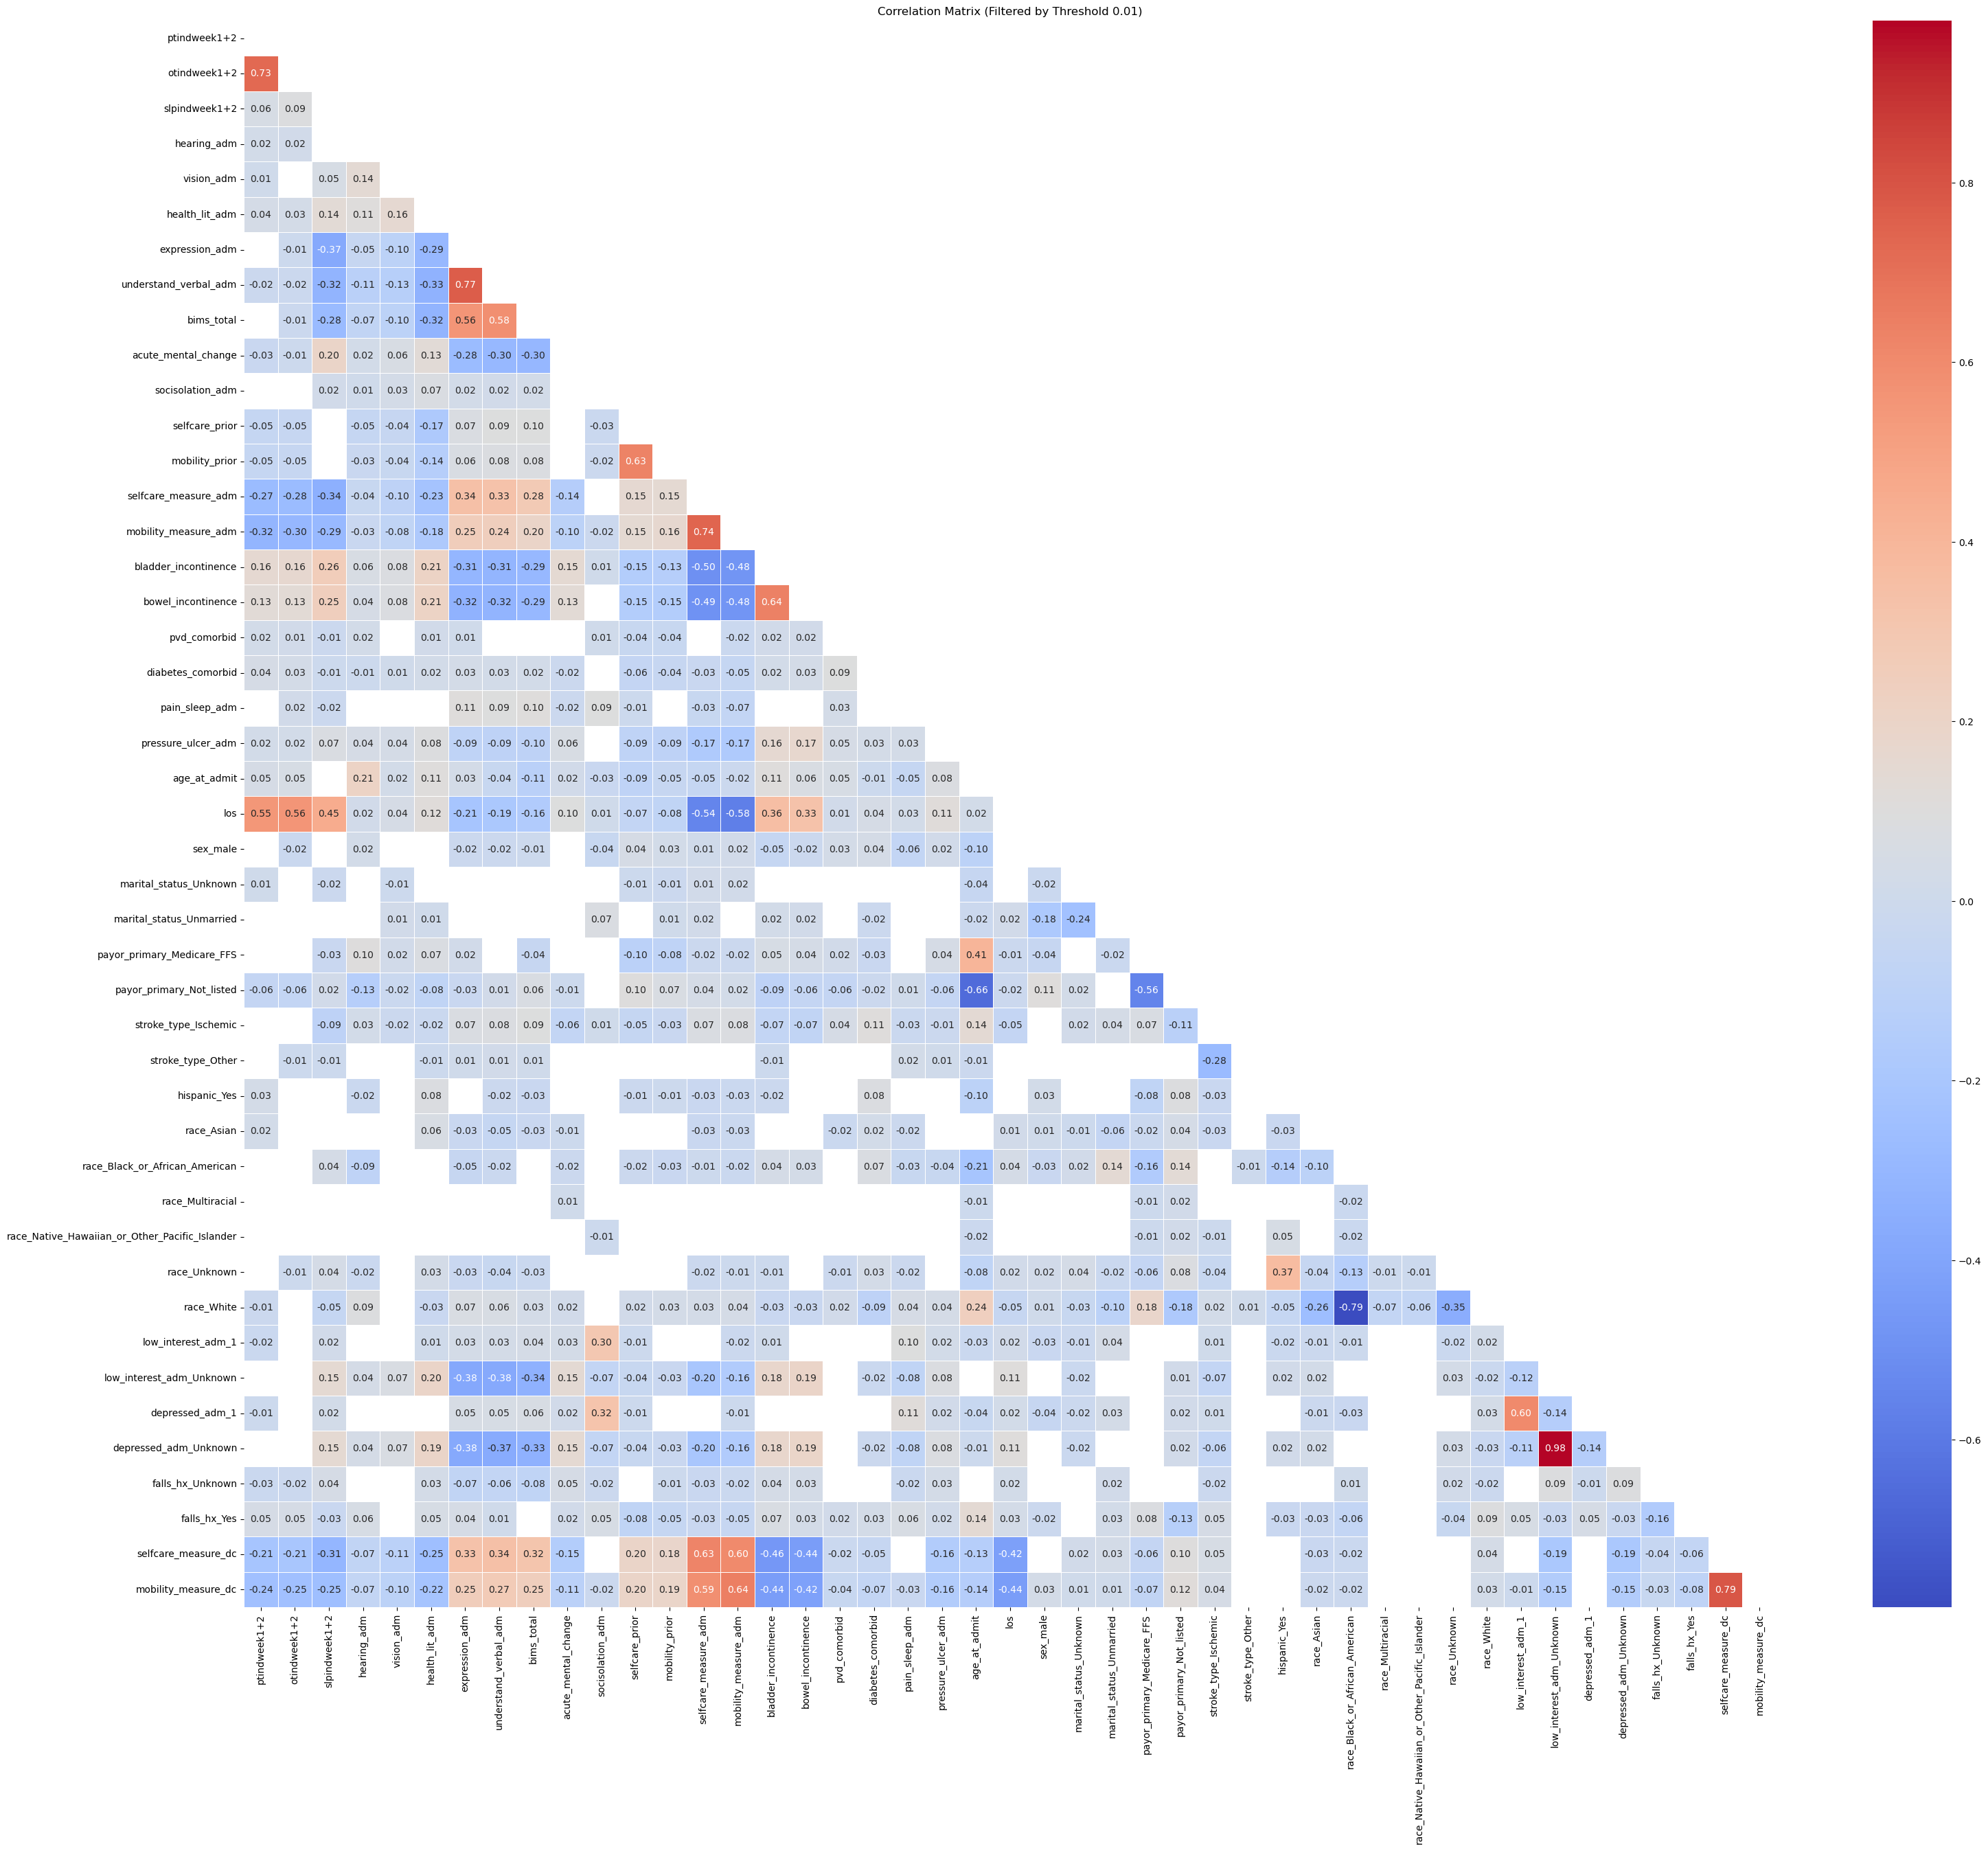

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TH = 0.01
def generate_correlation_matrix(X, exclude_binary=True, threshold=0.01):
    """
    Generate and visualize the correlation matrix, optionally removing binary variables.

    Parameters:
    - X: DataFrame, predictor variables.
    - exclude_binary: bool, if True, exclude binary variables.
    - threshold: float, filters to show correlations above the threshold (absolute value).

    Returns:
    - corr_matrix: Correlation matrix.
    """
    # Exclude binary variables (columns with only 0 and 1 as unique values)
    if exclude_binary:
        X_filtered = X.loc[:, X.nunique() > 2]
    else:
        X_filtered = X

    # Compute the correlation matrix
    corr_matrix = X_filtered.corr()

    # Filter correlations based on the threshold
    corr_to_plot = corr_matrix.where(np.abs(corr_matrix) > threshold, np.nan)

    # Plot the correlation matrix
    plt.figure(figsize=(36, 30))
    if exclude_binary:
        plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_to_plot, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        linewidths=0.5, 
        mask=np.triu(np.ones_like(corr_to_plot, dtype=bool))  # Mask upper triangle
    )
    plt.title(f"Correlation Matrix (Filtered by Threshold {TH})")
    plt.savefig('correlation_matrix.png')
    plt.show()

    return corr_matrix


correlation_matrix = generate_correlation_matrix(df, exclude_binary=False, threshold=TH)


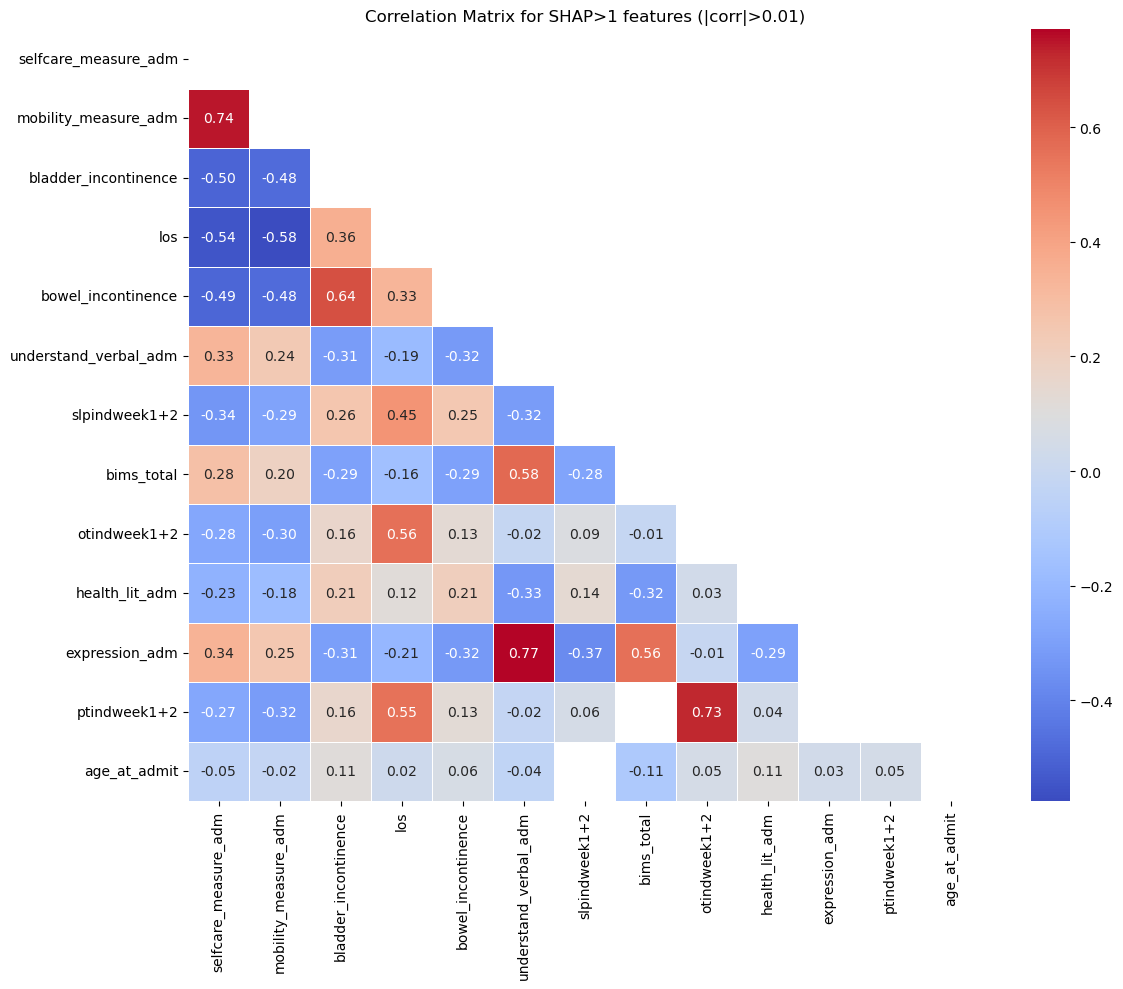

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TH = 0.01

# 1) hard‑coded list of all features whose SHAP > 1 in either model
important_features = [
    'selfcare_measure_adm',
    'mobility_measure_adm',
    'bladder_incontinence',
    'los',
    'bowel_incontinence',
    'understand_verbal_adm',
    'slpindweek1+2',
    'bims_total',
    'otindweek1+2',
    'health_lit_adm',
    'expression_adm',
    'ptindweek1+2',
    'age_at_admit',
]

def plot_corr_for_important(df,
                            features,
                            exclude_binary=True,
                            threshold=TH):
    """
    Plot correlation matrix only for `features`.
    """
    X = df.loc[:, features].copy()
    
    # optionally strip out pure‑binary cols
    if exclude_binary:
        X = X.loc[:, X.nunique() > 2]
    
    corr = X.corr()
    corr_to_plot = corr.where(np.abs(corr) > threshold, np.nan)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_to_plot,
        annot=True,
        cmap="coolwarm", 
        fmt=".2f",
        linewidths=0.5,
        mask=np.triu(np.ones_like(corr_to_plot, dtype=bool))
    )
    plt.title(f"Correlation Matrix for SHAP>1 features (|corr|>{threshold})")
    plt.tight_layout()
    plt.savefig('correlation_matrix_important.png')
    plt.show()
    
    return corr

# call it:
corr_matrix = plot_corr_for_important(df, important_features,
                                      exclude_binary=False,
                                      threshold=TH)
